# Assignment CBOW (using negative sampling)

what i add/change

1.  use 30 song lyrics dataset 

2. tokenize using spacy

3. make random_batch function can adjust window size and change input to be outside word and input to be center word, then change it's name to cbow_random_batch

4. can show traning time



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
import pandas as pd

# Read the CSV file which contain spotify song lyric 
df = pd.read_csv("C:\\Users\\ASUS\\My_Journal\\Text\\My-NLP\\spotify_millsongdata.csv")

# Randomly select 30 song
sample = df.sample(30)


In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 50699 to 39771
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  30 non-null     object
 1   song    30 non-null     object
 2   link    30 non-null     object
 3   text    30 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [4]:
import spacy

corpus = sample["text"]
#load 
nlp = spacy.load("en_core_web_sm")
# reduce space and use spacy to tokenize
sparcy_tokenized = [nlp(' '.join(lyric.split())) for lyric in corpus]
# convert scapy token to str
corpus_tokenized = [[str(word) for word in sublist] for sublist in sparcy_tokenized]

In [5]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]

vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = len(word2index)  #usually <UNK> is 0

#create index2word dictionary
#2 min    
index2word = {v:k for k, v in word2index.items()}


## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [6]:
def cbow_random_batch(batch_size, corpus, window_size=1):
    
    cbows = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        # # start from window_size end at window_size before last
        for i in range(window_size,len(sent)-window_size):
            center_word = word2index[sent[i]]
            # outside words 
            outside_words = [word2index[sent[j]] for j in range(max(0, i - window_size), min(len(sent), i + window_size + 1)) if j != i]
            for o in outside_words:
                # append outside word as input center word as output
                cbows.append([o, center_word])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(cbows)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([cbows[index][0]])  #outside words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([cbows[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)


## 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [7]:
#basically create a distribution of all the words you have in your vocabs

In [8]:
z = 0.001  #scaling up low frequency terms

In [9]:
#count all the occurrences of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
# word_count

In [10]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

7662

In [11]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

## 4. Negative sampling

A function to get negative samples, based on the current center and outside words in the batch

In [12]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [13]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

## 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [14]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()


## 4. Training

In [15]:
voc_size   = len(vocabs)
batch_size = 10 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = SkipgramNeg(voc_size, emb_size)
window_size = 2
num_neg = 10
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [16]:

import time

num_epochs = 5000
#start time
start_time = time.time()
pre_time = start_time
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = cbow_random_batch(batch_size, corpus,window_size)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table,num_neg)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        curr_time = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {curr_time-pre_time:.2f} sec")
        pre_time = curr_time

print(f"total time : {curr_time-start_time:.2f} sec")

Epoch 1000 | Loss: 1.277991 | Time: 43.99 sec
Epoch 2000 | Loss: 1.195928 | Time: 42.07 sec
Epoch 3000 | Loss: 2.617133 | Time: 40.73 sec
Epoch 4000 | Loss: 4.347378 | Time: 41.59 sec
Epoch 5000 | Loss: 2.524072 | Time: 45.48 sec
total time : 213.85 sec


## 5. Plot the embeddings

Is really the related stuff are close to each other, and vice versa?

The most fun part:  Will "banana" closer to "fruit" than "cat"?

In [23]:
word2index["Oh"]

708

In [17]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


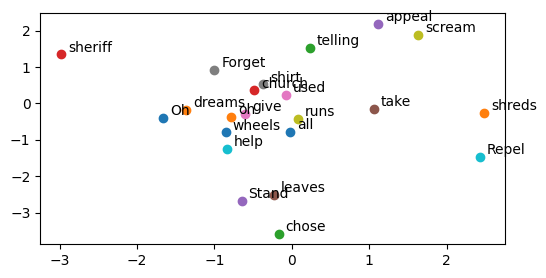

In [25]:
# plot matplotlib
plt.figure(figsize=(6,3))

x, y = get_embed("Oh")
plt.scatter(x, y)
plt.annotate("Oh", xy=(x, y), xytext=(5, 2), textcoords='offset points')
x, y = get_embed("oh")
plt.scatter(x, y)
plt.annotate("oh", xy=(x, y), xytext=(5, 2), textcoords='offset points')

for i, word in enumerate(vocabs[0:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

How do (from scratch) calculate cosine similarity?

In [26]:
from numpy import dot
from numpy.linalg import norm

def cos_similarity(word1,word2):
    a = get_embed(word1)
    b = get_embed(word2)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return cos_sim

word1 = "situation"
word2 = "all"
word3 = "big"
print(f"{word1} and {word2} similarity : {cos_similarity(word1,word2):.3f}")
print(f"{word3} and {word2} similarity : {cos_similarity(word3,word2):.3f}")
print(f"{word1} and {word3} similarity : {cos_similarity(word1,word3):.3f}")
    

situation and all similarity : 0.997
big and all similarity : 0.099
situation and big similarity : 0.177
